In [91]:
from IPython import display

import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Download MNIST dataset
X_mnist, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
# Normalize data
X_mnist = X_mnist / 255.0
X_mnist_ones = X_mnist[y == '1']

In [92]:
X_mnist_ones.shape

(7877, 784)

In [93]:
from torch import nn
import torch
import pytorch_lightning as pl

class VAE(pl.LightningModule):
    def __init__(self, mnist_ones, enc_out_dim=256, latent_dim=128):
        super().__init__()

        self.save_hyperparameters()

        self.mnist_ones = mnist_ones
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        # distribution parameters
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_var = nn.Linear(4096, latent_dim)


        self.decoder_linear = nn.Sequential(
            nn.Linear(latent_dim, 4096),
            nn.LeakyReLU())
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

        self.outputer = nn.Upsample(size=(28, 28))
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x = batch[0]

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        
        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        z_t = self.decoder_linear(z).reshape(-1, 256, 4, 4)
        # decoded
        x_hat = self.decoder(z_t)
        x_hat = nn.Upsample(size=(28, 28))(x_hat)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
        })
        self.log('elbo', elbo, on_step=False, on_epoch=True, prog_bar=True)

        return elbo
    
    def generate(self, n=1):
        with torch.no_grad():
            z = torch.randn(n, self.hparams.latent_dim, device=self.device)
            z_t = self.decoder_linear(z).reshape(-1, 256, 4, 4)
            x_hat = self.decoder(z_t)
            x_hat = self.outputer(x_hat)
            return x_hat
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=0.0001, weight_decay=0.1
        )
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, 0.0001)
        return [optimizer]#, [scheduler]
    
    def on_train_epoch_end(self) -> None:
        mnist_tranformed = self.mnist_ones.reshape(-1, 784)
        generated_mnist = self.generate(n=mnist_tranformed.shape[0]).reshape(-1, 784).cpu().numpy()
        y = np.concatenate([np.zeros(mnist_tranformed.shape[0]), np.ones(mnist_tranformed.shape[0])], axis=0)
        X = np.concatenate([mnist_tranformed, generated_mnist], axis=0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=10)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        self.log('knn_accuracy', accuracy, prog_bar=True)

In [94]:
vae = VAE(X_mnist_ones)
example_input = torch.rand(1, 1, 28, 28)
vae.training_step([example_input], 0)

/home/sahcim/dev/uwr-data-science-master/deep-lab/venv/lib/python3.11/site-packages/pytorch_lightning/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(771.3814, grad_fn=<MeanBackward0>)

In [95]:
torch.tensor(X_mnist_ones).repeat(3,1,1,1).shape

torch.Size([3, 1, 7877, 784])

In [96]:
from torch.utils.data import DataLoader, TensorDataset

X_mnist_ones = X_mnist_ones.reshape(-1, 1, 28, 28)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = TensorDataset(torch.tensor(X_mnist_ones).repeat(10,1,1,1).float())
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

vae = VAE(mnist_ones=X_mnist_ones, latent_dim=256)


best_model_callback = pl.callbacks.ModelCheckpoint(
    monitor='knn_accuracy',
    mode='min',
    save_last=True,
    save_top_k=1,
    dirpath='./checkpoints',
    filename='best_model_{epoch:02d}_{knn_accuracy:.2f}',
)

trainer = pl.Trainer(
            devices=1,
            accelerator="gpu",
            precision="16-mixed",
            max_epochs=30,
            accumulate_grad_batches=1,
            gradient_clip_val=5,
            logger=False,
            callbacks=[best_model_callback]
        )
trainer.fit(vae, dataloader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sahcim/dev/uwr-data-science-master/deep-lab/venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/sahcim/dev/uwr-data-science-master/deep-lab/week3/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 370 K 
1 | fc_mu          | Linear     | 1.0 M 
2 | fc_var         | Linear     | 1.0 M 
3 | decoder_linear | Sequential | 1.1 M 
4 | decoder        | Sequential | 369 K 
5 | outputer       | Upsample   | 0     
  | other params   | n/a        | 1     
----------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.563 

Epoch 29: 100%|██████████| 616/616 [00:03<00:00, 176.22it/s, elbo=-541., knn_accuracy=0.560]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 616/616 [00:04<00:00, 148.43it/s, elbo=-541., knn_accuracy=0.560]


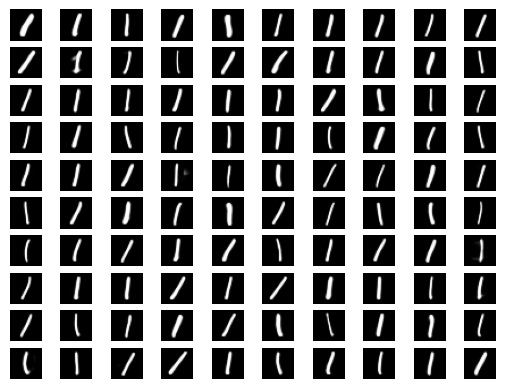

In [98]:
example = vae.generate(100)

#subplots
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(example[i].squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')